# POC: Acceleration Estimation Smoothing with Multiple Exogenous Noise Sources and Long Term Drift

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from pytorch_lightning.callbacks import ModelCheckpoint

## Synthetic Data

In [34]:
# Example usage
AMPLITUDE = 1.0
FREQUENCY = 2.0
DAMPING_FACTOR = 0.1
TIME_START = 0.0
TIME_END = 10.0
NUM_SAMPLES = 15360


#RNN and LSTM parameters
SEQUENCE_LENGTH = 128

In [35]:
def nonlinear_noise_with_trend(input_signal, degree=2, coeff_range=(-0.5, 0.5), trend_coeff=0.1):
    coefficients = np.random.uniform(coeff_range[0], coeff_range[1], degree + 1)

    #rushing to plane, change this to be configurable
    output_signal = np.polyval(coefficients, input_signal) +  0.1 * np.random.randn(input_signal.shape[0])
    
    return output_signal

def generate(noise_std=0.0):
    time = np.linspace(TIME_START, TIME_END, NUM_SAMPLES)
    angular_frequency = 2 * np.pi * FREQUENCY
    exponential_decay = np.exp(-DAMPING_FACTOR * time)
    oscillation = AMPLITUDE * np.cos(angular_frequency * time)
    if noise_std > 0.0:
        #todo: more principled imaginary transfer function between laser amplitude/frequency and configurable noise
        data = nonlinear_noise_with_trend(oscillation * exponential_decay)
    else:
        data = oscillation * exponential_decay

    return time, data

# Run the simulation
time, positions = generate(0.1)
time, ground_truth= generate()

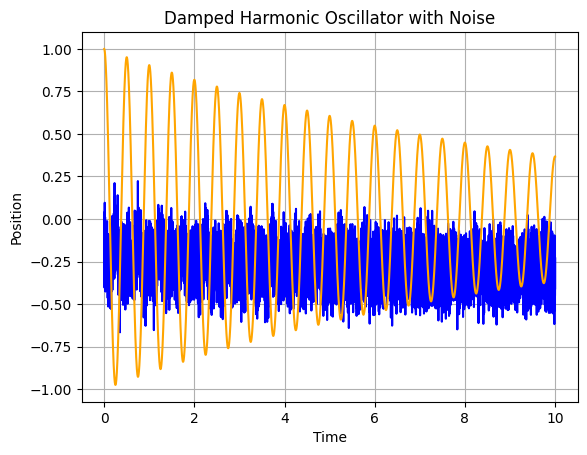

In [36]:
# Plot the results
plt.plot(time, positions, color='blue', label='Noisy')
plt.plot(time, ground_truth, color='orange', label='Ground Truth')
plt.xlabel('Time')
plt.ylabel('Position')
plt.title('Damped Harmonic Oscillator with Noise')
plt.grid(True)
plt.show()

In [37]:
import torch
import torch.nn as nn
# Define the loss function
criterion = nn.MSELoss()

## Kalman Filter

In [38]:
from filterpy.kalman import KalmanFilter
import numpy as np

def create_kalman():
    kf = KalmanFilter(dim_x=1, dim_z=1)

    # state transition matrix
    kf.F = np.array([[1.]])
    # measurement function matrix
    kf.H = np.array([[1.]])
    # covariance matrix // process noise
    kf.Q = np.array([[0.1]])
    # covariance matrix // measurement noise 
    kf.R = np.array([[1.]])
    # initialize state
    kf.x = np.array([[0.]])
    # initialize covariance matrix 
    kf.P = np.array([[1.]])
    return kf 

In [39]:
#tensorify everything

gt = torch.tensor(ground_truth, dtype=torch.float32).unsqueeze(1)

data = torch.tensor(positions, dtype=torch.float32).unsqueeze(1)

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from torch.utils.data import TensorDataset
import torch.nn.functional as F

class RNNAutoencoder(pl.LightningModule):
    def __init__(self, input_dim, hidden_dim, encoder_dim, n_layers, batch_size, dropout=0.6):
        super(RNNAutoencoder, self).__init__()
        self.dropout = nn.Dropout(dropout)
        self.criterion = nn.MSELoss(reduction='mean')
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        # encoder layers
        self.lstm1 = nn.LSTM(input_dim, hidden_dim, n_layers, dropout=dropout, batch_first=True)#, bidirectional=True)
        self.fc1 = nn.Linear(hidden_dim, encoder_dim)

        # decoder layers
        self.fc2 = nn.Linear(encoder_dim, hidden_dim)
        self.lstm2 = nn.LSTM(hidden_dim, input_dim, n_layers, dropout=dropout, batch_first=True)
        
        self.hidden1, self.hidden2 = self.init_hidden(batch_size)


    def forward(self, x):
        batch_size = x.size(0)
        self.hidden1 = tuple([each.data for each in self.hidden1])
        self.hidden2 = tuple([each.data for each in self.hidden2])
        opt = self.optimizers()
        opt.zero_grad()

        # decode
        lstm_dec, hidden1 = self.lstm1(x, self.hidden1)
        lstm_dec = lstm_dec.contiguous().view(-1, self.hidden_dim)
        dec = self.dropout(lstm_dec)
        dec = F.relu(self.fc1(dec))

        # encode
        enc = F.relu(self.fc2(dec))
        enc = self.dropout(enc)

        lstm_enc = enc.view(batch_size, -1, self.hidden_dim)
        lstm_enc, hidden2 = self.lstm2(lstm_enc, self.hidden2)
        
        
        self.hidden1 = hidden1
        self.hidden2 = hidden2

        return lstm_enc
    
    def validation_step(self, batch, batch_idx):
        x = batch
        reconstructed = self(x)
        loss = criterion(reconstructed, x)
        self.log("val_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def training_step(self, batch, batch_idx):
        x = batch
        reconstructed = self(x)
        loss = criterion(reconstructed, x)
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True, logger=True)
        return loss


    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=0.001)

    def init_hidden(self, batch_size, gpu=True):
        weight = next(self.parameters()).data
        
        hidden1 = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_())
        hidden2 = (weight.new(self.n_layers, batch_size, self.input_dim).zero_(),
                  weight.new(self.n_layers, batch_size, self.input_dim).zero_())
        return hidden1, hidden2


#make this work for even-sized batches or enforce some other way
train_size = int(0.75 * NUM_SAMPLES)
test_size = NUM_SAMPLES - train_size

def partition_tensor(tensor, k):
    num_samples = tensor.shape[0]

    # Determine the number of samples in each fold
    samples_per_fold = num_samples // k

    # Partition the tensor into k folds
    folds = torch.split(tensor[:k*samples_per_fold], samples_per_fold)

    return folds

#ground truth, 0.75 of observations
train_set = torch.stack(partition_tensor(gt[:train_size], 64))
#real-world, 0.25 (tail) of observations
val_set = torch.stack(partition_tensor(gt[- (NUM_SAMPLES - train_size):], 64))


model_chkpt = ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    dirpath='saved_models',
    filename='best_model'
)

In [41]:
class Dataset(pl.LightningDataModule):
    def __init__(self, train, val, batch_size=8):
        super().__init__()
        self.train = train
        self.val = val 
        self.batch_size = batch_size

    def setup(self, stage=None):
        self.train_set = TensorDataset(self.train)
        self.val_set = TensorDataset(self.val)

    def train_dataloader(self):
        return DataLoader(self.train ,batch_size=self.batch_size, shuffle=False,num_workers=8 )
    
    def val_dataloader(self):
        return DataLoader(val_set, batch_size=self.batch_size, shuffle=False, num_workers=8)

In [16]:
data_module = Dataset(train_set, val_set)

# Instantiate the LSTM Autoencoder
n_layers =  1
hidden_size = 32
input_size = 1
encoder_size = 32
rnn_ae = RNNAutoencoder(input_size, hidden_size, encoder_size,  n_layers, 8)

# Create a PyTorch Lightning Trainer
trainer = pl.Trainer(accelerator='cpu',  max_epochs=100, devices=1, callbacks= [model_chkpt])  # Set the desired number of epochs and number of GPUs

# Start the training
trainer.fit(rnn_ae, data_module)

/Users/laurenmoos/miniconda3/envs/torch/lib/python3.8/site-packages/torch/nn/modules/rnn.py:71: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.6 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/laurenmoos/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:201: UserWarning: MPS available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='mps', devices=1)`.
  rank_zero_warn(
/Users/laurenmoos/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to

/Users/laurenmoos/miniconda3/envs/torch/lib/python3.8/site-packages/pytorch_lightning/loops/fit_loop.py:280: PossibleUserWarning: The number of training batches (8) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  rank_zero_warn(


Epoch 0: 100%|█████████████████████████| 8/8 [00:01<00:00,  4.61it/s, v_num=128]
Validation: 0it [00:00, ?it/s]
Epoch 0: 100%|█████████| 8/8 [00:03<00:00,  2.27it/s, v_num=128, val_loss=0.100]
Epoch 1: 100%|█| 8/8 [00:02<00:00,  3.23it/s, v_num=128, val_loss=0.100, train_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 51.37it/s]
Epoch 1: 100%|█| 8/8 [00:04<00:00,  1.73it/s, v_num=128, val_loss=0.0806, train_
Epoch 2: 100%|█| 8/8 [00:02<00:00,  3.46it/s, v_num=128, val_loss=0.0806, train_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 84.65it/s]
Epoch 2: 100%|█| 8/8 [00:04<00:00,  1.81it/s, v_num=128, val_loss=0.060, train_l
Epoch 3: 100%|█| 8/8 [00:02<00:00,  3.38it/s, v_num=128, val_loss=0.060, train_l
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 120.47it/s]
Epoch 3: 100%|█| 8/8 [00:04<00:00,  1.78it/s, v_num=128, val_loss=

Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 43.03it/s]
Epoch 8: 100%|█| 8/8 [00:04<00:00,  1.75it/s, v_num=128, val_loss=0.0254, train_
Epoch 9: 100%|█| 8/8 [00:02<00:00,  3.39it/s, v_num=128, val_loss=0.0254, train_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 27.04it/s]
Epoch 9: 100%|█| 8/8 [00:04<00:00,  1.78it/s, v_num=128, val_loss=0.024, train_l
Epoch 10: 100%|█| 8/8 [00:02<00:00,  3.42it/s, v_num=128, val_loss=0.024, train_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 50.80it/s]
Epoch 10: 100%|█| 8/8 [00:04<00:00,  1.77it/s, v_num=128, val_loss=0.0258, train
Epoch 11: 100%|█| 8/8 [00:02<00:00,  3.35it/s, v_num=128, val_loss=0.0258, train
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 58.79it/s]
Epoch 11: 100%|█| 8/8 [00:04<00:00,  1.73it/s, v_num=128, val_loss=0.0225, train
Epoch 12: 100%|█

Epoch 17: 100%|█| 8/8 [00:02<00:00,  3.34it/s, v_num=128, val_loss=0.012, train_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 42.64it/s]
Epoch 17: 100%|█| 8/8 [00:04<00:00,  1.72it/s, v_num=128, val_loss=0.0119, train
Epoch 18: 100%|█| 8/8 [00:02<00:00,  3.31it/s, v_num=128, val_loss=0.0119, train
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 47.06it/s]
Epoch 18: 100%|█| 8/8 [00:04<00:00,  1.70it/s, v_num=128, val_loss=0.0105, train
Epoch 19: 100%|█| 8/8 [00:02<00:00,  3.33it/s, v_num=128, val_loss=0.0105, train
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 59.46it/s]
Epoch 19: 100%|█| 8/8 [00:04<00:00,  1.72it/s, v_num=128, val_loss=0.0097, train
Epoch 20: 100%|█| 8/8 [00:02<00:00,  3.34it/s, v_num=128, val_loss=0.0097, train
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:

Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 64.86it/s]
Epoch 25: 100%|█| 8/8 [00:04<00:00,  1.66it/s, v_num=128, val_loss=0.00696, trai
Epoch 26: 100%|█| 8/8 [00:02<00:00,  3.27it/s, v_num=128, val_loss=0.00696, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 197.74it/s]
Epoch 26: 100%|█| 8/8 [00:04<00:00,  1.71it/s, v_num=128, val_loss=0.00694, trai
Epoch 27: 100%|█| 8/8 [00:02<00:00,  3.27it/s, v_num=128, val_loss=0.00694, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 126.91it/s]
Epoch 27: 100%|█| 8/8 [00:04<00:00,  1.69it/s, v_num=128, val_loss=0.00675, trai
Epoch 28: 100%|█| 8/8 [00:02<00:00,  3.43it/s, v_num=128, val_loss=0.00675, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 122.22it/s]
Epoch 28: 100%|█| 8/8 [00:04<00:00,  1.77it/s, v_num=128, val_loss=0.00663, trai
Epoch 29: 100%|█

Epoch 34: 100%|█| 8/8 [00:02<00:00,  2.97it/s, v_num=128, val_loss=0.00559, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 74.65it/s]
Epoch 34: 100%|█| 8/8 [00:05<00:00,  1.50it/s, v_num=128, val_loss=0.00569, trai
Epoch 35: 100%|█| 8/8 [00:02<00:00,  2.86it/s, v_num=128, val_loss=0.00569, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 101.57it/s]
Epoch 35: 100%|█| 8/8 [00:05<00:00,  1.50it/s, v_num=128, val_loss=0.00548, trai
Epoch 36: 100%|█| 8/8 [00:02<00:00,  2.92it/s, v_num=128, val_loss=0.00548, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 80.86it/s]
Epoch 36: 100%|█| 8/8 [00:05<00:00,  1.54it/s, v_num=128, val_loss=0.00539, trai
Epoch 37: 100%|█| 8/8 [00:02<00:00,  2.99it/s, v_num=128, val_loss=0.00539, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:

Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 38.06it/s]
Epoch 42: 100%|█| 8/8 [00:05<00:00,  1.45it/s, v_num=128, val_loss=0.00469, trai
Epoch 43: 100%|█| 8/8 [00:03<00:00,  2.61it/s, v_num=128, val_loss=0.00469, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 88.94it/s]
Epoch 43: 100%|█| 8/8 [00:05<00:00,  1.40it/s, v_num=128, val_loss=0.00487, trai
Epoch 44: 100%|█| 8/8 [00:02<00:00,  2.70it/s, v_num=128, val_loss=0.00487, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 59.32it/s]
Epoch 44: 100%|█| 8/8 [00:05<00:00,  1.42it/s, v_num=128, val_loss=0.00443, trai
Epoch 45: 100%|█| 8/8 [00:02<00:00,  2.75it/s, v_num=128, val_loss=0.00443, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 150.98it/s]
Epoch 45: 100%|█| 8/8 [00:05<00:00,  1.44it/s, v_num=128, val_loss=0.00463, trai
Epoch 46: 100%|█

Epoch 51: 100%|█| 8/8 [00:02<00:00,  2.73it/s, v_num=128, val_loss=0.00405, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 119.65it/s]
Epoch 51: 100%|█| 8/8 [00:05<00:00,  1.47it/s, v_num=128, val_loss=0.0039, train
Epoch 52: 100%|█| 8/8 [00:02<00:00,  3.01it/s, v_num=128, val_loss=0.0039, train
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 69.70it/s]
Epoch 52: 100%|█| 8/8 [00:05<00:00,  1.59it/s, v_num=128, val_loss=0.00394, trai
Epoch 53: 100%|█| 8/8 [00:02<00:00,  3.13it/s, v_num=128, val_loss=0.00394, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 55.97it/s]
Epoch 53: 100%|█| 8/8 [00:05<00:00,  1.55it/s, v_num=128, val_loss=0.0039, train
Epoch 54: 100%|█| 8/8 [00:02<00:00,  2.94it/s, v_num=128, val_loss=0.0039, train
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:0

Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 65.39it/s]
Epoch 59: 100%|█| 8/8 [00:05<00:00,  1.59it/s, v_num=128, val_loss=0.00345, trai
Epoch 60: 100%|█| 8/8 [00:02<00:00,  3.08it/s, v_num=128, val_loss=0.00345, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 140.79it/s]
Epoch 60: 100%|█| 8/8 [00:04<00:00,  1.62it/s, v_num=128, val_loss=0.0036, train
Epoch 61: 100%|█| 8/8 [00:02<00:00,  2.90it/s, v_num=128, val_loss=0.0036, train
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 40.73it/s]
Epoch 61: 100%|█| 8/8 [00:05<00:00,  1.42it/s, v_num=128, val_loss=0.00344, trai
Epoch 62: 100%|█| 8/8 [00:03<00:00,  2.66it/s, v_num=128, val_loss=0.00344, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 73.33it/s]
Epoch 62: 100%|█| 8/8 [00:05<00:00,  1.43it/s, v_num=128, val_loss=0.00351, trai
Epoch 63: 100%|█

Epoch 68: 100%|█| 8/8 [00:02<00:00,  3.22it/s, v_num=128, val_loss=0.00328, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 108.24it/s]
Epoch 68: 100%|█| 8/8 [00:04<00:00,  1.69it/s, v_num=128, val_loss=0.0033, train
Epoch 69: 100%|█| 8/8 [00:02<00:00,  3.14it/s, v_num=128, val_loss=0.0033, train
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 32.71it/s]
Epoch 69: 100%|█| 8/8 [00:04<00:00,  1.66it/s, v_num=128, val_loss=0.00325, trai
Epoch 70: 100%|█| 8/8 [00:02<00:00,  3.13it/s, v_num=128, val_loss=0.00325, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 59.46it/s]
Epoch 70: 100%|█| 8/8 [00:04<00:00,  1.64it/s, v_num=128, val_loss=0.0032, train
Epoch 71: 100%|█| 8/8 [00:02<00:00,  3.15it/s, v_num=128, val_loss=0.0032, train
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:

Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 203.93it/s]
Epoch 76: 100%|█| 8/8 [00:04<00:00,  1.68it/s, v_num=128, val_loss=0.00308, trai
Epoch 77: 100%|█| 8/8 [00:02<00:00,  3.20it/s, v_num=128, val_loss=0.00308, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 138.89it/s]
Epoch 77: 100%|█| 8/8 [00:04<00:00,  1.71it/s, v_num=128, val_loss=0.00306, trai
Epoch 78: 100%|█| 8/8 [00:02<00:00,  3.15it/s, v_num=128, val_loss=0.00306, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 192.64it/s]
Epoch 78: 100%|█| 8/8 [00:04<00:00,  1.66it/s, v_num=128, val_loss=0.00308, trai
Epoch 79: 100%|█| 8/8 [00:02<00:00,  3.10it/s, v_num=128, val_loss=0.00308, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 59.70it/s]
Epoch 79: 100%|█| 8/8 [00:04<00:00,  1.64it/s, v_num=128, val_loss=0.00301, trai
Epoch 80: 100%|█

Epoch 85: 100%|█| 8/8 [00:02<00:00,  3.05it/s, v_num=128, val_loss=0.00315, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 54.42it/s]
Epoch 85: 100%|█| 8/8 [00:05<00:00,  1.50it/s, v_num=128, val_loss=0.00305, trai
Epoch 86: 100%|█| 8/8 [00:02<00:00,  2.73it/s, v_num=128, val_loss=0.00305, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 141.70it/s]
Epoch 86: 100%|█| 8/8 [00:05<00:00,  1.47it/s, v_num=128, val_loss=0.00305, trai
Epoch 87: 100%|█| 8/8 [00:02<00:00,  2.84it/s, v_num=128, val_loss=0.00305, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 122.22it/s]
Epoch 87: 100%|█| 8/8 [00:05<00:00,  1.47it/s, v_num=128, val_loss=0.00301, trai
Epoch 88: 100%|█| 8/8 [00:02<00:00,  2.75it/s, v_num=128, val_loss=0.00301, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:0

Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 159.44it/s]
Epoch 93: 100%|█| 8/8 [00:05<00:00,  1.54it/s, v_num=128, val_loss=0.00297, trai
Epoch 94: 100%|█| 8/8 [00:02<00:00,  3.13it/s, v_num=128, val_loss=0.00297, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 30.44it/s]
Epoch 94: 100%|█| 8/8 [00:04<00:00,  1.60it/s, v_num=128, val_loss=0.00295, trai
Epoch 95: 100%|█| 8/8 [00:02<00:00,  3.07it/s, v_num=128, val_loss=0.00295, trai
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|████████████████▋  | 7/8 [00:00<00:00, 114.37it/s]
Epoch 95: 100%|█| 8/8 [00:04<00:00,  1.63it/s, v_num=128, val_loss=0.003, train_
Epoch 96: 100%|█| 8/8 [00:02<00:00,  3.22it/s, v_num=128, val_loss=0.003, train_
Validation: 0it [00:00, ?it/s]
Validation DataLoader 0:  88%|█████████████████▌  | 7/8 [00:00<00:00, 51.46it/s]
Epoch 96: 100%|█| 8/8 [00:04<00:00,  1.64it/s, v_num=128, val_loss=0.00293, trai
Epoch 97: 100%|█

`Trainer.fit` stopped: `max_epochs=100` reached.


Epoch 99: 100%|█| 8/8 [00:05<00:00,  1.39it/s, v_num=128, val_loss=0.00294, trai


In [17]:
def test_generalization(gt, ckpt, kf):
    
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=[18, 12])
    noises = [0.01, 0.1, 0.5]

    # Loop through each subplot and plot the data
    for i, ax in enumerate(axes.flatten()):
        
        #prepare data
        noise_val = noises[i]
        time, noisy = generate(noise_val)
        time, gt = generate()
        gt = torch.tensor(gt, dtype =torch.float32).unsqueeze(1)
        test = partition_tensor(torch.tensor(noisy, dtype=torch.float32).unsqueeze(1), 64)
        
        dl = DataLoader(test, batch_size=8, shuffle=False)
        out = trainer.predict(rnn_ae, dataloaders=dl)
        r = torch.cat([o.reshape(-1) for o in out ])
        
        #kalman filter inference
        fxs = []
        for x in noisy:
            kf.predict()
            kf.update(x)
            fxs.append(kf.x[0, 0 ])
        fxs = torch.tensor(fxs, dtype=torch.float32).unsqueeze(1)
        
        ax.plot(time, fxs, color='grey', label = 'Kalman Filtered')
        ax.plot(time, noisy, color = 'blue', label = 'Noisy')
        ax.plot(time, r, color = 'orange', label = 'AE Smoothed')
        ax.plot(time, gt, color = 'yellow', label = 'Ground Truth')

        # Add legend
        ax.legend()

        ax.set_xlabel('Time')
        ax.set_ylabel('Position')
        print(r.shape)
        print(gt.shape)
        loss = criterion(r, gt)
        kalman_loss = criterion(fxs, gt)
        ax.set_title(f'Noise  {noise_val} Loss {loss:.2f} Kalman Loss {kalman_loss:.4f}')
        ax.grid(True)


In [ ]:
kf = create_kalman()

test_generalization(gt, '', kf)